In [ ]:
pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 24kB/s 
     |████████████████████████████████| 12.8MB 35.6MB/s 
     |████████████████████████████████| 7.6MB 6.0MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from os.path import exists

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

7.0.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/kt_sdg_train.zip -d train
!unzip -q /content/gdrive/MyDrive/kt_sdg_val.zip -d val

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Jan 25 22:49:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
unlabeler = LabelEncoder()
labels = [path.parent.name for path in train_files]
unlabeler.fit(labels)
with open('label_sdg_smalla_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(unlabeler, le_dump_file)

In [ ]:
class KTDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, encoder):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = encoder

        if self.mode != 'test':
            self.labels = torch.FloatTensor([1 if path.parent.name=="СДГ" else 0 for path in self.files])
            

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            return x, label
        
    def _prepare_sample(self, image):
        image = image.crop((470, 0, 1449, 979))
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
import random

In [ ]:
TRAIN_DIR = Path('train/kt_sdg_train')
train_files = list(TRAIN_DIR.rglob('*.jpg'))
random.shuffle(train_files)
print(train_files)

[PosixPath('train/kt_sdg_train/СДГ отсутствует/3D_MPR_-_YUMAKOV_V_I\u200e_(62y)_-_22.10.2020_19_39_04_-__Head_0.5_0069.jpg'), PosixPath('train/kt_sdg_train/СДГ отсутствует/3D_MPR_-_Belish_I.V.\u200e_(56y)_-_06.08.2020_23_33_29_-__Head_0.5_0029.jpg'), PosixPath('train/kt_sdg_train/СДГ отсутствует/3D_MPR_-_AMELINA__Z.D.\u200e_(78y)_-_12.10.2020_9_43_41_-_SFT_1.25_0142.jpg'), PosixPath('train/kt_sdg_train/СДГ отсутствует/3D_MPR_-_ISHDAVLETOV_YU_D\u200e_(74y)_-_29.09.2020_9_36_14_-__Head_0.5_0194.jpg'), PosixPath('train/kt_sdg_train/СДГ отсутствует/3D_MPR_-_SALAMATOVA_E_N\u200e_(38y)_-_26.10.2020_2_31_35_-_Head__1.0__J30s_0027.jpg'), PosixPath('train/kt_sdg_train/СДГ отсутствует/3D_MPR_-_CHERMNYKH_S_V\u200e_(51y)_-_23.09.2020_0_38_41_-_Hel_1.25mm_0077.jpg'), PosixPath('train/kt_sdg_train/СДГ отсутствует/3D_MPR_-_IVANOV_S_A\u200e_(65y)_-_14.10.2020_8_16_58_-_Head__1.0__J30s_0036.jpg'), PosixPath('train/kt_sdg_train/СДГ отсутствует/3D_MPR_-_RIBOLOVLEVA__L_A\u200e_(75y)_-_05.08.2020_22_03_27_

In [ ]:
VAL_DIR = Path('val/kt_sdg_val')
val_files=list(VAL_DIR.rglob('*.jpg'))
random.shuffle(val_files)
print(val_files)

[PosixPath('val/kt_sdg_val/СДГ отсутствует/3D_MPR_-_BORISOVA_V.I_KORP1\u200e_(82y)_-_28.09.2020_10_44_00_-_HEAD_STAND__1.5__H31s_0064.jpg'), PosixPath('val/kt_sdg_val/СДГ отсутствует/3D_MPR_-_KOLESNIKOVA_I_N\u200e_(62y)_-_18.10.2020_23_11_23_-__Head_0.5_0033.jpg'), PosixPath('val/kt_sdg_val/СДГ отсутствует/3D_MPR_-_KOLESNIKOVA_I_N\u200e_(62y)_-_18.10.2020_23_11_23_-__Head_0.5_0048.jpg'), PosixPath('val/kt_sdg_val/СДГ отсутствует/3D_MPR_-_KABIEVA_A\u200e_(81y)_-_02.10.2020_20_46_25_-__Head_0.5_0100.jpg'), PosixPath('val/kt_sdg_val/СДГ отсутствует/3D_MPR_-_KABIEVA_A\u200e_(81y)_-_02.10.2020_20_46_25_-__Head_0.5_0099.jpg'), PosixPath('val/kt_sdg_val/СДГ/3D_MPR_-_SBRODOV__M_F\u200e_(48y)_-_09.10.2020_13_26_07_-_Hel_1.25mm_0012.jpg'), PosixPath('val/kt_sdg_val/СДГ отсутствует/3D_MPR_-_KOLESNIKOVA_I_N\u200e_(62y)_-_18.10.2020_23_11_23_-__Head_0.5_0055.jpg'), PosixPath('val/kt_sdg_val/СДГ/3D_MPR_-_SBRODOV__M_F\u200e_(48y)_-_09.10.2020_13_26_07_-_Hel_1.25mm_0048.jpg'), PosixPath('val/kt_sdg_va

In [ ]:
val_dataset = KTDataset(val_files, mode='val', encoder=unlabeler)
print(len(val_dataset))

351


In [ ]:
train_dataset = KTDataset(train_files, mode = 'train', encoder=unlabeler)

In [ ]:
print(len(train_files))

10067


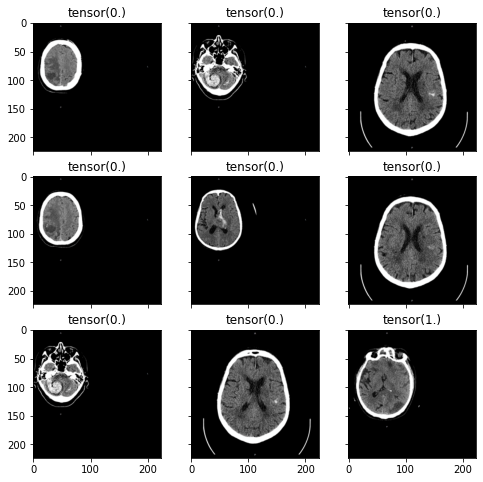

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,260))
    im_val, label = val_dataset[random_characters]
    img_label = label
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
import torch.nn as nn

class SmallCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )

        self.out = nn.Linear(32, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # print(x.shape)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits


In [ ]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [ ]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
def macro_soft_f1(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

In [ ]:
from torchvision import datasets, models, transforms

num_classes=1
torch.manual_seed(42)
np.random.seed(42)

base_model=SmallCnn(num_classes)

base_model=base_model.to(DEVICE)

# loss_fn = f1_loss

# optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-2)

# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        # print(inputs.shape)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        # print(outputs.shape)
        try:
            outputs=torch.reshape(outputs, (64,))
        except:
            outputs=torch.reshape(outputs, (19,))
        # print(outputs.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 0)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    # all_f1=0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            try:
                outputs=torch.reshape(outputs, (64,))
            except:
                outputs=torch.reshape(outputs, (31,))
            
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 0)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        # f1_metr=f1_score(labels.cpu(), preds.cpu(), average=None)
        # all_f1+=f1_metr
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    # f1_result=all_f1/processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.BCEWithLogitsLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            torch.save(model.state_dict(), "gdrive/MyDrive/KT_binary_sdg_smalla_"+str(epoch+1)+".pth")
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
print(base_model)

SmallCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
history = train(train_dataset, val_dataset, model=base_model, epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.06630307701759072


epoch:   3%|▎         | 1/30 [04:52<2:21:14, 292.22s/it]


Epoch 001 train_loss: 0.0663     val_loss 0.9719 train_acc 0.0003 val_acc 0.0000
loss 0.03567914180979362


epoch:   7%|▋         | 2/30 [09:41<2:15:58, 291.39s/it]


Epoch 002 train_loss: 0.0357     val_loss 1.3918 train_acc 0.0250 val_acc 0.1709
loss 0.01561222979489459


epoch:  10%|█         | 3/30 [14:29<2:10:37, 290.28s/it]


Epoch 003 train_loss: 0.0156     val_loss 1.6926 train_acc 0.0186 val_acc 0.1709
loss 0.010954196220342705


epoch:  13%|█▎        | 4/30 [19:17<2:05:27, 289.52s/it]


Epoch 004 train_loss: 0.0110     val_loss 1.4945 train_acc 0.0129 val_acc 0.1709
loss 0.008815975201304059


epoch:  17%|█▋        | 5/30 [24:05<2:00:26, 289.05s/it]


Epoch 005 train_loss: 0.0088     val_loss 2.1320 train_acc 0.0193 val_acc 0.1709
loss 0.008908103953197629


epoch:  20%|██        | 6/30 [28:52<1:55:28, 288.69s/it]


Epoch 006 train_loss: 0.0089     val_loss 1.8032 train_acc 0.0128 val_acc 0.1709
loss 0.0035312784366564993


epoch:  23%|██▎       | 7/30 [33:40<1:50:31, 288.32s/it]


Epoch 007 train_loss: 0.0035     val_loss 2.0009 train_acc 0.0129 val_acc 0.1709
loss 0.0027754782890412094


epoch:  27%|██▋       | 8/30 [38:29<1:45:45, 288.45s/it]


Epoch 008 train_loss: 0.0028     val_loss 2.1346 train_acc 0.0249 val_acc 0.1709
loss 0.0020579602168343666


epoch:  30%|███       | 9/30 [43:19<1:41:12, 289.17s/it]


Epoch 009 train_loss: 0.0021     val_loss 2.5965 train_acc 0.0001 val_acc 0.1709
loss 0.0017069413909508112


epoch:  33%|███▎      | 10/30 [48:10<1:36:30, 289.53s/it]


Epoch 010 train_loss: 0.0017     val_loss 2.1924 train_acc 0.0064 val_acc 0.1709
loss 0.0017762803227059224


epoch:  37%|███▋      | 11/30 [52:59<1:31:37, 289.34s/it]


Epoch 011 train_loss: 0.0018     val_loss 1.9337 train_acc 0.0003 val_acc 0.1709
loss 0.0006144918873034206


epoch:  40%|████      | 12/30 [57:48<1:26:48, 289.38s/it]


Epoch 012 train_loss: 0.0006     val_loss 1.7755 train_acc 0.0125 val_acc 0.1709
loss 0.001175227769259927


epoch:  43%|████▎     | 13/30 [1:02:40<1:22:13, 290.18s/it]


Epoch 013 train_loss: 0.0012     val_loss 3.4028 train_acc 0.0189 val_acc 0.1709
loss 0.004910089471493799


epoch:  47%|████▋     | 14/30 [1:07:33<1:17:33, 290.86s/it]


Epoch 014 train_loss: 0.0049     val_loss 3.0048 train_acc 0.0190 val_acc 0.1709
loss 0.0016027687531751877


epoch:  50%|█████     | 15/30 [1:12:26<1:12:54, 291.64s/it]


Epoch 015 train_loss: 0.0016     val_loss 2.3182 train_acc 0.0253 val_acc 0.1709
loss 0.000549383704785565


epoch:  53%|█████▎    | 16/30 [1:17:20<1:08:10, 292.19s/it]


Epoch 016 train_loss: 0.0005     val_loss 2.7482 train_acc 0.0127 val_acc 0.1709
loss 0.00017628104299424922


epoch:  57%|█████▋    | 17/30 [1:22:13<1:03:24, 292.62s/it]


Epoch 017 train_loss: 0.0002     val_loss 2.9756 train_acc 0.0191 val_acc 0.1709
loss 0.0002533856874223463


epoch:  60%|██████    | 18/30 [1:27:07<58:34, 292.88s/it]


Epoch 018 train_loss: 0.0003     val_loss 3.1265 train_acc 0.0067 val_acc 0.1709
loss 0.00025813354093650665


epoch:  63%|██████▎   | 19/30 [1:32:00<53:43, 293.07s/it]


Epoch 019 train_loss: 0.0003     val_loss 3.3847 train_acc 0.0378 val_acc 0.1709
loss 0.0010163520883361568


epoch:  67%|██████▋   | 20/30 [1:36:54<48:52, 293.24s/it]


Epoch 020 train_loss: 0.0010     val_loss 3.2815 train_acc 0.0126 val_acc 0.1709
loss 0.000543350203588027


epoch:  70%|███████   | 21/30 [1:41:48<44:00, 293.37s/it]


Epoch 021 train_loss: 0.0005     val_loss 3.3842 train_acc 0.0189 val_acc 0.1709
loss 0.00044984470610375183


epoch:  73%|███████▎  | 22/30 [1:46:41<39:08, 293.51s/it]


Epoch 022 train_loss: 0.0004     val_loss 3.2522 train_acc 0.0007 val_acc 0.1709
loss 0.00393845774415907


epoch:  77%|███████▋  | 23/30 [1:51:35<34:15, 293.68s/it]


Epoch 023 train_loss: 0.0039     val_loss 4.7214 train_acc 0.0186 val_acc 0.1709
loss 0.00026028383055232894


epoch:  80%|████████  | 24/30 [1:56:28<29:19, 293.22s/it]


Epoch 024 train_loss: 0.0003     val_loss 3.2309 train_acc 0.0318 val_acc 0.1709
loss 0.000675304072069277


epoch:  83%|████████▎ | 25/30 [2:01:18<24:21, 292.23s/it]


Epoch 025 train_loss: 0.0007     val_loss 3.9827 train_acc 0.0185 val_acc 0.1709
loss 0.0003303181505961671


epoch:  87%|████████▋ | 26/30 [2:06:06<19:24, 291.20s/it]


Epoch 026 train_loss: 0.0003     val_loss 3.4317 train_acc 0.0131 val_acc 0.1709
loss 0.0005511222707211921


epoch:  90%|█████████ | 27/30 [2:10:56<14:32, 290.78s/it]


Epoch 027 train_loss: 0.0006     val_loss 4.6891 train_acc 0.0002 val_acc 0.1709
loss 0.00015336179464056176


epoch:  93%|█████████▎| 28/30 [2:15:46<09:41, 290.57s/it]


Epoch 028 train_loss: 0.0002     val_loss 4.1363 train_acc 0.0131 val_acc 0.1709
loss 0.0001079951943685835


epoch:  97%|█████████▋| 29/30 [2:20:36<04:50, 290.42s/it]


Epoch 029 train_loss: 0.0001     val_loss 4.5655 train_acc 0.0071 val_acc 0.1709
loss 0.00035385028661901683


epoch: 100%|██████████| 30/30 [2:25:26<00:00, 290.90s/it]


Epoch 030 train_loss: 0.0004     val_loss 5.1067 train_acc 0.0128 val_acc 0.1709


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

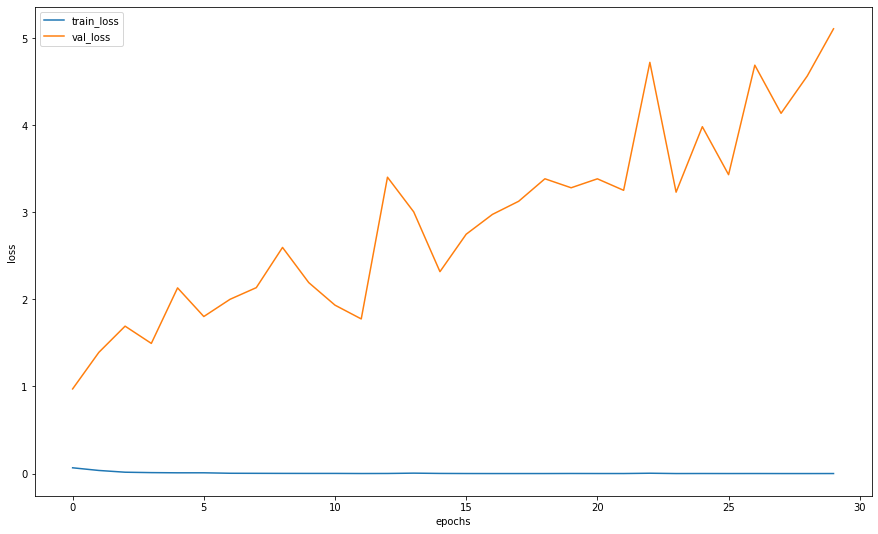

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    print(logits)
    probs = nn.functional.sigmoid(torch.cat(logits)).numpy()
    probs = [1 if i>=0.5 else 0 for i in probs]
    return probs

idxs = list(map(int, np.random.uniform(0,260,100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)
print(probs_ims)

actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score

print(actual_labels)
print(probs_ims)
print(f1_score(actual_labels, probs_ims, average=None))

nice=0
for i in range(100):
    if actual_labels[i]==probs_ims[i]:
      nice+=1
print(nice)

[tensor([[-23.2056]]), tensor([[-38.4479]]), tensor([[-16.4782]]), tensor([[-35.9255]]), tensor([[-31.3452]]), tensor([[-31.3452]]), tensor([[-31.6104]]), tensor([[-35.4263]]), tensor([[-37.8084]]), tensor([[-21.1141]]), tensor([[-21.5099]]), tensor([[-43.1130]]), tensor([[-34.9647]]), tensor([[-23.5398]]), tensor([[-32.2579]]), tensor([[-32.2579]]), tensor([[-37.4905]]), tensor([[-34.7836]]), tensor([[-32.1705]]), tensor([[-36.6588]]), tensor([[-38.2908]]), tensor([[-31.1993]]), tensor([[-36.6588]]), tensor([[-26.9302]]), tensor([[-34.1694]]), tensor([[-36.4226]]), tensor([[-28.1202]]), tensor([[-25.2724]]), tensor([[-35.4764]]), tensor([[-23.7611]]), tensor([[-38.6103]]), tensor([[-32.5393]]), tensor([[-31.0628]]), tensor([[-38.4408]]), tensor([[-42.3367]]), tensor([[-35.2239]]), tensor([[-37.4905]]), tensor([[-26.1930]]), tensor([[-25.3297]]), tensor([[-32.2200]]), tensor([[-29.9965]]), tensor([[-26.1955]]), tensor([[-23.3713]]), tensor([[-41.9698]]), tensor([[-19.2973]]), tensor([[

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), ten

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,260))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(base_model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,260,100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

In [ ]:
# actual_labels=[label_encoder.classes_[i] for i in actual_labels]
print(actual_labels)
print(y_pred)

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)


In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,2808))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
torch.save(base_model.state_dict(), "gdrive/MyDrive/KT_binary_sdg_smalla_v2_last.pth")

In [ ]:
def predict_picture(file_name):
    TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

    test_files = list(TEST_DIR.rglob(file_name))

    test_dataset = KTDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(base_model, test_loader)
    print(probs)
    predicted_proba = np.max(probs)*100
    for i in range(len(probs[0])):
      print(probs[0][i]*100, label_encoder.classes_[i])
    y_pred = np.argmax(probs)
    predicted_label = label_encoder.classes_[y_pred]
    return predicted_label, predicted_proba

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
print(predict_picture("10.jpg"))

[[2.3849365e-05 7.8634754e-02 9.4841748e-02 3.5471048e-02 3.6185865e-09
  9.6606191e-06 1.3273510e-01 2.4622777e-03 3.6915779e-08 1.2144416e-04
  3.2435180e-04 4.2660564e-02 6.1262834e-01 8.6691303e-05]]
0.0023849364879424684 ВЖК
7.8634753823280334 ВМГ 1
9.484174847602844 ВМГ 2
3.5471048206090927 ВМГ_ВЖК
3.6185865415205853e-07 ВМГ_ВЖК_САК
0.0009660619070928078 ВМГ_ВЖК_ишем
13.273510336875916 ВМГ_ишемия
0.24622776545584202 САК
3.6915778878210403e-06 САК_ВЖК
0.01214441581396386 САК_ВМГ
0.03243518003728241 СД
4.266056418418884 ишемия
61.26283407211304 опухоль
0.008669130329508334 эд_сд
('опухоль', 61.26283407211304)


In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

val_files = list(TEST_DIR.rglob("*.jpg"))

In [ ]:
print(val_files)

[PosixPath('/content/gdrive/MyDrive/kt_test_fold/2.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/3.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/1.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/4.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/5.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/6.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/7.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/8.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/9.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/10.jpg')]


In [ ]:
val_dataset = KTDataset(val_files, mode='val')

In [ ]:
print(len(val_dataset))

10


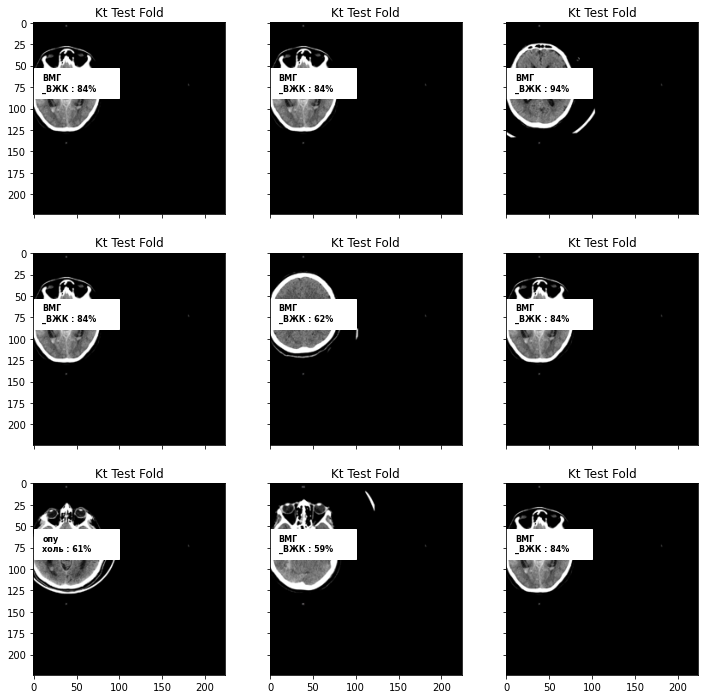

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

test_files = list(TEST_DIR.rglob("*.jpg"))

In [ ]:
test_dataset = KTDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(base_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

In [ ]:
print(preds)

['ВМГ_ВЖК' 'опухоль' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ 2'
 'ишемия' 'ВМГ_ВЖК' 'ВМГ_ВЖК']


In [ ]:
TRAIN_DIR = Path('train/Готовые снимки')
# TEST_DIR = Path('test/kt_test_data_test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
random.shuffle(train_val_files)
print(train_val_files)
# test_files = sorted(list(TEST_DIR.rglob('*.jpg')))